In [1]:
%%writefile rotation.py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from trajectories import Trajectories
test_traject = 5

traject = Trajectories()
Xs, y, y_inicial = traject.generate_train_test_trajects(test_traject)

def rotate(tra, ang):
    
    theta = (ang/180) * np.pi
    device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
    
    

    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta),  np.cos(theta)]])
    
    r = torch.zeros_like(tra).cpu().detach().numpy()
    print(r.ndim)
    if r.ndim == 3:
        for k in range(0, tra.size()[0]):
            tra1 = tra.cpu().detach().numpy()
            r[k,:,:] = tra1[k,:,:]@rot_matrix
    else:
            tra1 = tra.cpu().detach().numpy()
            r[:,:] = tra1[:,:]@rot_matrix
    return r

# y2 = rotate(y, 90)
# y_inicial2 = rotate(y_inicial, 180)

# fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

# ax1.plot(y[0,:,0].cpu().detach().numpy(), y[0,:,1].cpu().detach().numpy(), c = 'r', label = 'original', marker = '.')
# plt.legend()

# ax2.plot(y2[0,:,0], y2[0,:,1], c = 'b', label = 'rotated', marker = '.')
# plt.legend()

Overwriting rotation.py


In [2]:
%%writefile trajectories.py
import numpy as np
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

mini_batch_size = 128
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

class Trajectories:

    def generate_train_test_trajects(self, type_traject):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in trajectories.py?: {torch.cuda.is_available ()}')
        
        Xs_t = torch.zeros([type_traject,N_despl,N_coord], device=device) 
        y_t = torch.zeros([type_traject,N_despl,N_coord], device=device)
        y_inicial = torch.zeros([type_traject,N_coord], device=device)

#         Xs_t = Xs_t.to (device)
#         y_t = y_t.to (device)
#         y_inicial = y_inicial.to (device)
        
        print(f'Device cuda for y_inicial in trajectories.py:{y_inicial.is_cuda}')
        for k in range(type_traject):
            d360 = np.pi * 2
            ranX = np.zeros(N_despl)  
            des = np.ones(N_despl)*0.05

            for j in range(N_despl):
                if j == 0:
                    ranX[j] = float(np.random.uniform(0, d360, 1))
                else:
                    #ranX[j] = 0.95*ranX[j-1] + 0.05*(np.pi - float(np.random.uniform(0, d360, 1)))
                    ranX[j] = ranX[j-1] + float(np.random.uniform(-d360*0.1, d360*0.1, 1))


            cos = np.cos(ranX)

            sin = np.sin(ranX)

            ranY = []
            for i in range(len(cos)):
                ranY.append(des[i] / cos[i])

            Xak = []


            for i in range(len(ranX)):
                list1 = []
                list1.append(cos[i]*des[i])
                list1.append(sin[i]*des[i])
                Xak.append(list1)

            ylistk = []
            inicial = []

            for i in range(len(ranX)):
                coords = []
                if i == 0:
                    x_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][0]), limit_arena-np.abs(Xak[i][0]), 1))
                    y_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][1]), limit_arena-np.abs(Xak[i][1]), 1))
                    coords.append(Xak[i][0] + x_cond_in)
                    coords.append(Xak[i][1] + y_cond_in)
                    ylistk.append(coords)  # posiciones iniciales en x e y
                    inicial.append(x_cond_in)
                    inicial.append(y_cond_in)
                else:
                    x_coord = cos[i]*des[i] + ylistk[i - 1][0]
                    y_coord = sin[i]*des[i] + ylistk[i - 1][1]
                    if limit_arena2 < y_coord < limit_arena and limit_arena2 < x_coord < limit_arena:
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif x_coord <= limit_arena2 or x_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif y_coord <= limit_arena2 or y_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord <= limit_arena2:
                    #     x_coord = limit_arena
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord >= limit_arena:
                    #     x_coord = limit_arena2
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord <= limit_arena2:
                    #     y_coord = limit_arena
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord >= limit_arena:
                    #     y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)


            Xsk = torch.tensor([Xak], device=device)
            yk = torch.tensor([ylistk], device=device)
            inicial = torch.tensor([inicial], device=device)

            y_inicial[k,:] = inicial
            Xs_t[k,:,:] = Xsk
            y_t[k,:,:] = yk

            
            Xs = Xs_t
            y = y_t      
            

        return Xs, y, y_inicial
print("trajectories")

Overwriting trajectories.py


In [3]:
%%writefile model.py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

N_despl = 2
N_hidden_neurons = 100
N_softmax_neurons = 200

class NeuralNetwork(nn.Module):
            
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.linear = nn.Linear(N_despl, N_hidden_neurons, bias=False) #probar otra inicializacion, xavier
        nn.init.xavier_uniform_(self.linear.weight, gain=0.9)
        #nn.init.zeros_(self.linear.weight)
        self.Tanh = nn.ReLU() 

        self.M = torch.randn((N_despl, N_hidden_neurons))*0.01
        self.M = torch.nn.Parameter(self.M)


        self.linear2 = nn.Linear(N_hidden_neurons, N_hidden_neurons, bias=False)
        nn.init.orthogonal_(self.linear2.weight, gain=0.9)
        #nn.init.zeros_(self.linear2.weight)
        self.Tanh2 = nn.ReLU()
        
        

        self.linear4 = nn.Linear(N_hidden_neurons, N_softmax_neurons, bias=False)
        nn.init.uniform_(self.linear4.weight, -0.1, 0.1)
        #nn.init.zeros_(self.linear4.weight)

        #self.dropout = nn.Dropout(p=0.70)
        
        self.linear5 = nn.Linear(N_softmax_neurons, N_hidden_neurons, bias=False)
        nn.init.zeros_(self.linear5.weight)

        self.softmax = nn.Softmax(dim=1)

        self.linear3 = nn.Linear(N_softmax_neurons, N_despl, bias=False)
        nn.init.uniform_(self.linear3.weight, -0.1, 0.1)
        #nn.init.zeros_(self.linear3.weight) 


        
    def forward(self, input, x0, xretro):
         
        xin = self.linear(input)
        #noise =  torch.empty(x0.size(), device='cuda:0').normal_(mean=0,std=0.7)

        u0 = self.Tanh(x0)
        xrec = self.linear2(u0)       
        dx = (-x0 + xin + xrec + xretro) / 10 
        x1 = x0 + dx
        
        def add_noise(weights, noise):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
            weights.add_(noise)
        
        #r = 0.4
        #noise_linear2 = torch.randn(x1.size(), device='cuda:0')*r 
        
        
        #add_noise(x1, noise_linear2) #acotar para que el ruido complique 
         
        #adam diferente const aprendizaje para cada parametro    
        
        x2 = self.Tanh(x1)
        x2c = torch.clamp(x2, min=None, max=1)

        #x2cd = self.dropout(x2c)
        
        x3 = self.linear4(x2c)
        beta = 0.8
        x4 = x3*beta
        x5 = self.softmax(x4)
        
        xretro = self.linear5(x5)
        
        s = 0.02
        noise_linear3 = torch.randn(x5.size(), device='cuda:0')*s
        #add_noise(x5, noise_linear3)

        x6 = x5 + noise_linear3
        u1 = self.Tanh(x5)  
        yd = self.linear3(u1)
        

        return yd, x1, x3, xretro
    
    #mas neuronas
    #retroconexion de softmax a recurrente
    #division por norma de vector en lugar de softmax
    
    #batch-normalization? +mu / sigma


Overwriting model.py


In [4]:
import torch
import numpy as np
device = torch.device ("cpu")
permutationX = torch.randperm(10)
half = int(permutationX.detach().numpy().size/2)
permutationX2 = permutationX[0:half]
permutationX3 = permutationX[half:]
print(permutationX)
print(permutationX2)
print(permutationX3)
p = torch.cat((permutationX2, permutationX3))

print(p)

tensor([6, 9, 4, 3, 2, 5, 8, 7, 1, 0])
tensor([6, 9, 4, 3, 2])
tensor([5, 8, 7, 1, 0])
tensor([6, 9, 4, 3, 2, 5, 8, 7, 1, 0])


In [5]:
def distancia_modelo_real(tensor1, tensor2):
    x_distance = np.mean (np.abs ((tensor1[:, 0] - tensor2[:, 0])) / (np.max (tensor1[:, 0]) - np.min (tensor1[:, 0])))
    y_distance = np.mean (np.abs ((tensor1[:, 1] - tensor2[:, 1])) / (np.max (tensor1[:, 1]) - np.min (tensor1[:, 1])))
    return x_distance, y_distance
print('done')

done


In [6]:
%%writefile test.py
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories
from rotation import rotate

mini_batch_size = 128
N_mini_batch = 130
test_traject = 256
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 200

beta = 0.8



class Testing:

    
    def test_model(self):
        
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

        my_network = NeuralNetwork()
        my_network.to(device)
        my_network.M.to (device)
        
        
        mseloss = nn.MSELoss()
        #optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        
        traject = Trajectories()

        torch.save(my_network,'/kaggle/working/MyNetworkKaggleTest7.tar')
        
        batch_y1 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        y2 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        
        all_activation_test = torch.zeros(test_traject, N_despl, N_hidden_neurons, device=device)
        all_activation_soft_test = torch.zeros(test_traject, N_despl, N_softmax_neurons, device=device)
        
        Xs, y, y_inicial = traject.generate_train_test_trajects(test_traject)
        
        
        y_rot = rotate(y, 180)
        y_inicial_rot = rotate(y_inicial, 180)
        
        y_rot1 = torch.from_numpy(y_rot)
        y_rot1 = y_rot1.to(device)
        y_inicial_rot1 = torch.from_numpy(y_inicial_rot)
        y_inicial_rot1 = y_inicial_rot1.to(device)
        
        my_network.eval()
        
        with torch.inference_mode():
            permutationX = torch.randperm(Xs.size()[0], device=device)
            test_batch = 128
            
            for i in range(0,Xs.size()[0], test_batch): #iterate minibatch

                activation = torch.zeros ((test_batch,N_despl, N_hidden_neurons), device=device)
                activation_soft = torch.zeros ((test_batch,N_despl, N_softmax_neurons), device=device)


                # remove current gradients for next iteration
                #optimizer.zero_grad(set_to_none=True)
        
                firings = torch.zeros((test_batch, N_hidden_neurons), device=device)
                #firings = firings.to(device)
                firings_soft = torch.zeros((test_batch, N_softmax_neurons), device=device)
                #firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + test_batch]
                batch_x, batch_y = Xs[indicesX], y_rot1[indicesX]
                batch_x = batch_x.to(device)
                vect = y_inicial_rot1[indicesX]
                vect = vect.cuda()
                
                x0 = vect@my_network.M
                xretro = torch.zeros((test_batch, N_hidden_neurons), device=device)
                
                ytotal = torch.zeros(test_batch,N_despl,2, device=device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction
                    yhat, x0, x3, xretro = my_network.forward(batch_x[:,k,:], x0, xretro)
                    ytotal[:,k,:] = yhat

                    firing = torch.relu(x0)
                    activation[:,k,:] = firing

                    firing2 = x3
                    firing2 *= beta
                    firing_soft = torch.softmax(firing2, dim=1)
                    activation_soft[:,k,:] = firing_soft

                batch_y1[i:i + test_batch,:,:] = batch_y.detach()
                y2[i:i + test_batch,:,:] = ytotal.detach()


                all_activation_test[i:i + test_batch,:,:] = activation.detach()
                all_activation_soft_test[i:i + test_batch,:,:] = activation_soft.detach()


                # calculate MSE loss
                # coef = 0.05
                loss1 = mseloss (ytotal, batch_y)
                # loss2 = firings_mean
                # loss = loss1 * (1 - coef) + loss2 * coef
                #
                # # append to loss
                # current_loss += loss
        return loss1, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network



Overwriting test.py


In [7]:
%%writefile train.py
import os
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories
from rotation import rotate

mini_batch_size = 128
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 200
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

beta = 0.8


def add_noise(weights, noise):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    weights.add_(noise)  

class Training:
    
    
    
    def train_model(self):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in train.py?: {torch.cuda.is_available ()}')

        my_network = NeuralNetwork()
#         my_network.to(device)
#         my_network.M.to (device)
        
        #my_network = torch.load('/kaggle/working/MyNetworkKaggle5.tar')
        my_network.to(device)
        my_network.M.to (device)
        epochs = 1000
        
        
        mseloss = nn.MSELoss()
        
        optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        
        
#         optimizer = torch.optim.Adam(
#                         [
#                             {"params": my_network.linear.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear3.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear4.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear2.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear5.parameters(), "lr": 1e-3},
#                         ],
#                         lr=1e-3,
#                    )
        
        
        all_losses = torch.zeros(epochs, device=device)
        #all_losses.to(device)
#         all_losses1 = torch.zeros(epochs)
#         all_losses2 = torch.zeros(epochs)
        traject = Trajectories()
        Xs, y, y_inicial = traject.generate_train_test_trajects(train_traject)
        
        y_rot = rotate(y, 180)
        y_inicial_rot = rotate(y_inicial, 180)
        
        y_rot1 = torch.from_numpy(y_rot)
        y_rot1 = y_rot1.to(device)
        y_inicial_rot1 = torch.from_numpy(y_inicial_rot)
        y_inicial_rot1 = y_inicial_rot1.to(device)
        
        
        
        
        
        
        
        epoch = 0
        
        print('y size:')
        print(y.cpu().detach().numpy().size)
        print('y_rot1 size:')
        print(y_rot1.cpu().detach().numpy().size)
    

        plot_every = 100
        N_hidden_neurons = 100
        N_softmax_neurons = 200
        N_input_neurons = 2
        batch_y1 = torch.zeros(train_traject,N_despl,N_coord, device=device)
        y2 = torch.zeros(train_traject,N_despl,N_coord, device=device)
        
        all_activation = torch.zeros(train_traject, N_despl, N_hidden_neurons, device=device)
        all_activation_soft = torch.zeros(train_traject, N_despl, N_softmax_neurons, device=device)
        
    
    
#         my_network.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']
#         my_network.state_dict

        # peso = checkpoint['model_state_dict']['linear2.weight']
        # ones_diag = torch.ones(N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril(ones_diag, k=75)
        # ones_diag = torch.triu(ones_diag, k=25)
        # peso_d = ones_diag * peso
        # checkpoint['model_state_dict']['linear2.weight'] = peso_d
        #50 diagonales

        # ones_diag = torch.ones (N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril (ones_diag, diagonal=3)
        # ones_diag = torch.triu (ones_diag, diagonal=-3)

        ## disable cudnn fixed the mem leak problem
        torch.backends.cudnn.enabled = False
        prev_mem = 0
        pid = os.getpid()
        
        for ep in range(epoch, epoch+epochs):

            current_loss = 0
#             current_loss1 = 0
#             current_loss2 = 0
            permutationX = torch.randperm(Xs.size()[0], device=device)
            #permutationX = permutationX.to(device)
#             counter_batchs = 0

            for i in range(0,Xs.size()[0], mini_batch_size): #iterate minibatch N_mini_batch times

                activation = torch.zeros ((mini_batch_size,N_despl, N_hidden_neurons), device=device)
                activation_soft = torch.zeros ((mini_batch_size,N_despl, N_softmax_neurons), device=device)


                # remove current gradients for next iteration
                optimizer.zero_grad(set_to_none=True)
        
                firings = torch.zeros((mini_batch_size, N_hidden_neurons), device=device)
                #firings = firings.to(device)
                firings_soft = torch.zeros((mini_batch_size, N_softmax_neurons), device=device)
                #firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + mini_batch_size]
                
                half = int(indicesX.cpu().detach().numpy().size/2)
                indicesX2 = indicesX[0:half]
                indicesX3 = indicesX[half:]
                
                
                batch_y2 = y[indicesX2]
                batch_y3 = y_rot1[indicesX3]

                batch_y = torch.cat((batch_y2, batch_y3), dim=0)
                
                batch_x = Xs[indicesX]
                batch_x = batch_x.to(device)
                
                vect2 = y_inicial[indicesX2]
                vect3 = y_inicial_rot1[indicesX3]
                
                vect = torch.cat((vect2, vect3), dim=0)
                
                #input nuevo, one hot que marca cada contexto en nuevas neuronas de capa de entrada
                
                #probar cambiar los limites del bineado del histograma para evitar el exceso en ciertos angulos
                
                # 128,2   x    2,100
                x0 = vect@my_network.M
                xretro = torch.zeros((mini_batch_size, N_hidden_neurons), device=device)

                ytotal = torch.zeros(mini_batch_size,N_despl,2, device=device)
                #ytotal = ytotal.to(device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction

                    yhat, x0, x3, xretro = my_network.forward(batch_x[:,k,:], x0, xretro)
                    ytotal[:,k,:] = yhat
                    
                    firing = torch.relu(x0)
                    activation[:,k,:] = firing

                    firing2 = x3
                    firing2 *= beta
                    firing_soft = torch.softmax(firing2, dim=1)
                    activation_soft[:,k,:] = firing_soft
                    
                    #firings += firing
#                 print(f'Device cuda for ytotal in train.py:{ytotal.is_cuda}')
#                 print(f'Device cuda for batch_y in train.py:{batch_y.is_cuda}')
                
                batch_y1[i:i + mini_batch_size,:,:] = batch_y.detach()
                y2[i:i + mini_batch_size,:,:] = ytotal.detach()
            
            
                all_activation[i:i + mini_batch_size,:,:] = activation.detach()
                all_activation_soft[i:i + mini_batch_size,:,:] = activation_soft.detach()

                # calculate MSE loss

                # coef = 0.0001
                # firings_mean = torch.sum(firings) / (N_despl*N_hidden_neurons)
                with torch.cuda.amp.autocast():
                    loss1 = mseloss(ytotal, batch_y) # - var
                    #loss2 = firings_mean
                    loss = loss1 #* (1-coef) + loss2 * coef
                
                # backpropogate through the loss gradiants
                loss.backward()

                # update model weights   
                optimizer.step()
                
                # with torch.no_grad():
                #     peso = my_network.linear2.weight
                #     peso_d = torch.nn.Parameter(ones_diag * peso)
                #     my_network.linear2.weight = peso_d
                # 50 diagonales
                # np.triu


                # append to loss   
                current_loss += loss.cpu().detach().numpy()
                #current_loss1 += loss1.detach ().numpy ()
                #current_loss2 += loss2.detach().numpy()

            all_losses[ep-epoch] = current_loss
            #all_losses1.append(current_loss1 / N_mini_batch)
            #all_losses2.append(current_loss2 / N_mini_batch)



            # print progress
            if ep != 0 and ep % plot_every == 0:
                print(f'Epoch: {ep} completed')
                print(current_loss)
                # loss1 = [loss.detach().numpy() for loss in all_losses]
                # plt.plot(loss1)
                # plt.ylabel('Loss')
                # plt.xlabel('Epoch')
                # plt.show()
                cur_mem = (int(open('/proc/%s/statm'%pid, 'r').read().split()[1])+0.0)/256
                add_mem = cur_mem - prev_mem
                prev_mem = cur_mem
                print(f'added mem: {add_mem}')
                #print(my_network.linear4.weight.cpu().detach().numpy())

        torch.save(my_network,'/kaggle/working/MyNetworkKaggle2.tar')

#         torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': my_network.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': current_loss,
#                     }, '/kaggle/working/MyNetworkKaggle2.tar')

        return all_losses, all_activation, all_activation_soft, batch_y1, y2, my_network
print("train")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Overwriting train.py


trajectories
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
3
2
loss = 0.32117125391960144
done
Hidden layer


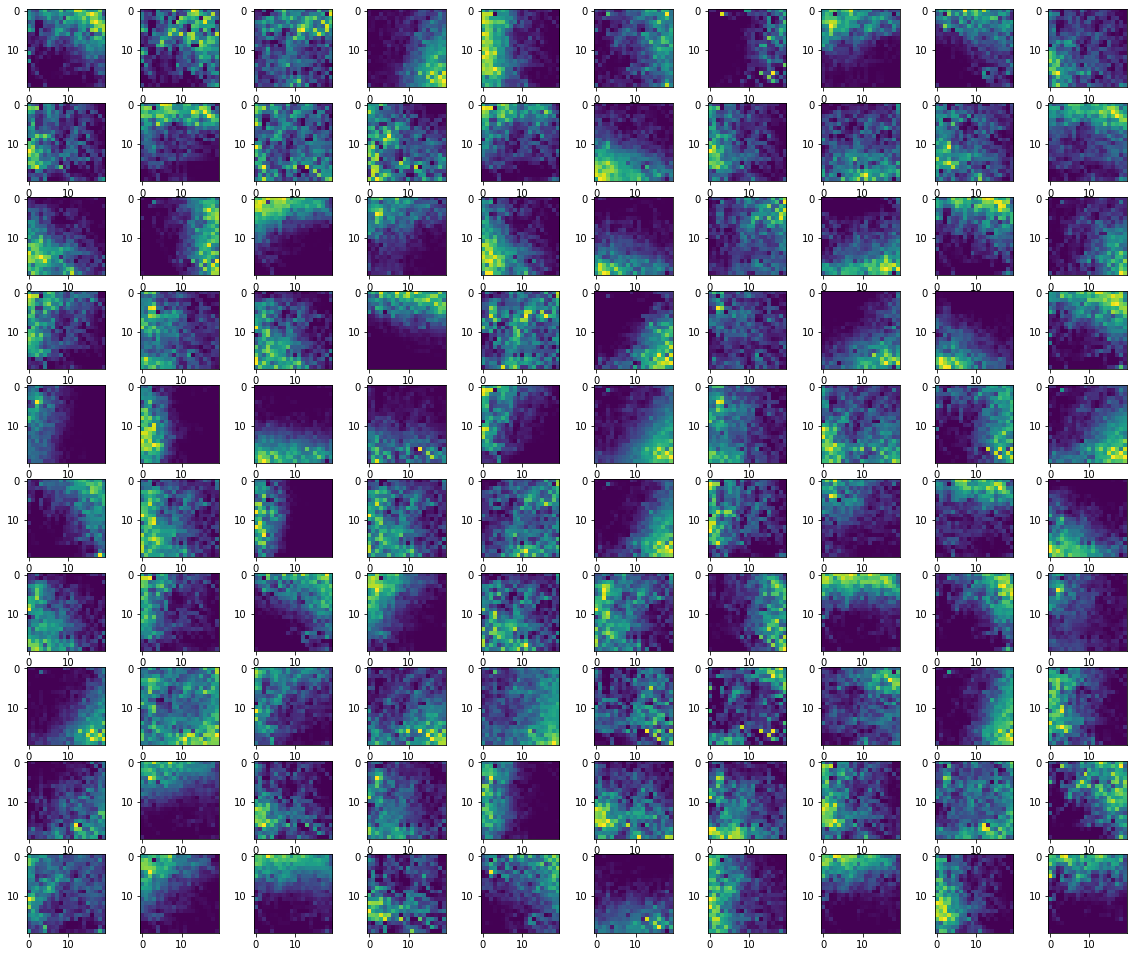

In [8]:
from test import Testing
import numpy as np
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 200
test_traject = 256
limit_arena = 1
limit_arena2 = -1

t_traject = test_traject
        
test = Testing()
loss1, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network  = test.test_model()

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)


act_array_test = np.array(all_activation_test.cpu().detach().numpy())
act_array1 = np.reshape(act_array_test, [linear_size, N_hidden_neurons], order = 'C')

final_array = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1
    
print(f'loss = {loss1}')
print('done')

final_array3 = final_array / counter

import matplotlib.pyplot as plt

N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array3[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons.png')

Hidden layer


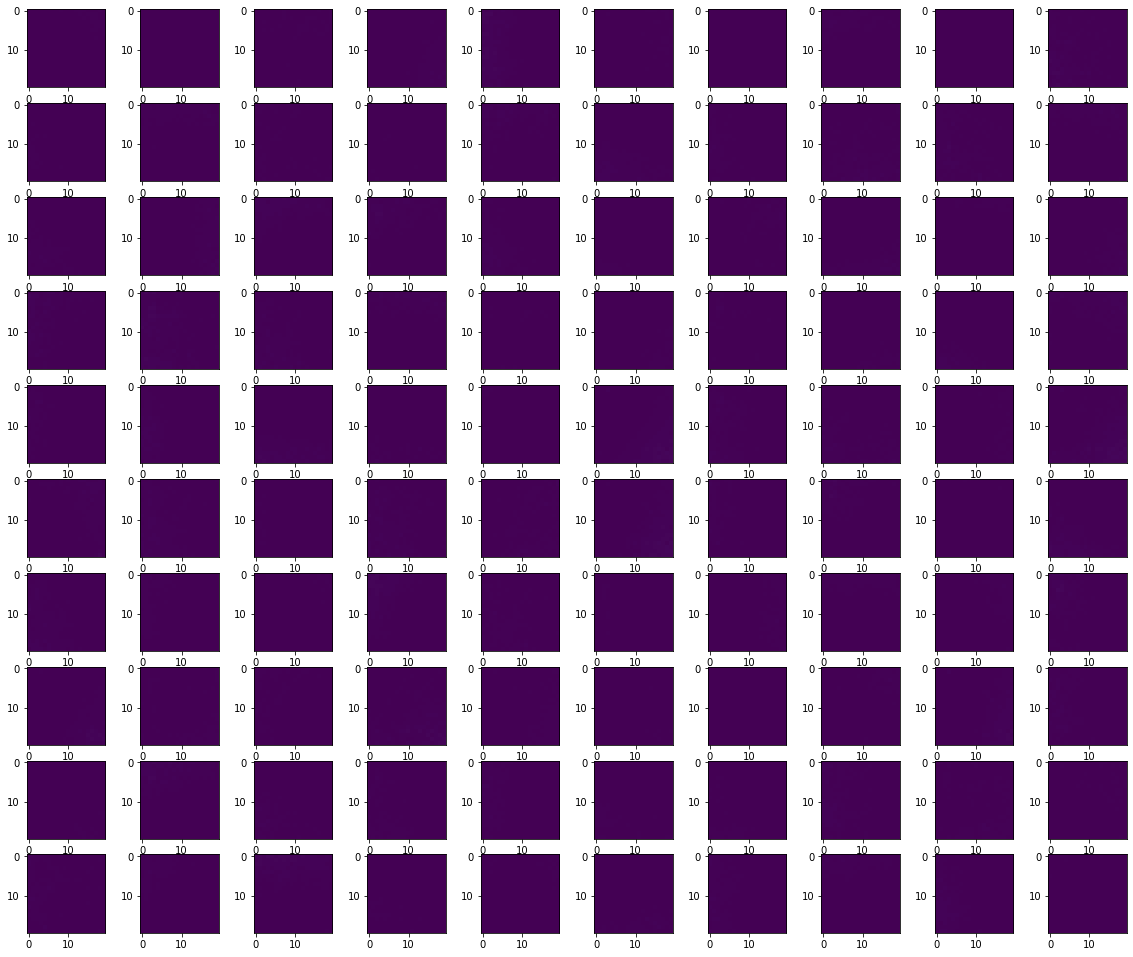

In [9]:
import matplotlib.pyplot as plt

N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array3[:,:,n], vmin=0, vmax=1)
print('Hidden layer')
plt.savefig('hidden_neurons.png')

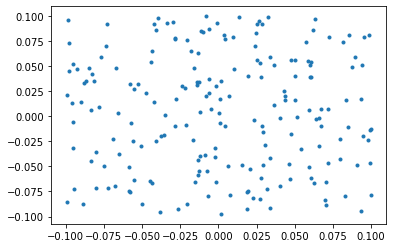

In [10]:

peso = my_network.linear3.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

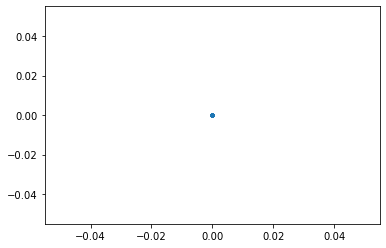

In [11]:
peso = my_network.linear5.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

Softmax layer


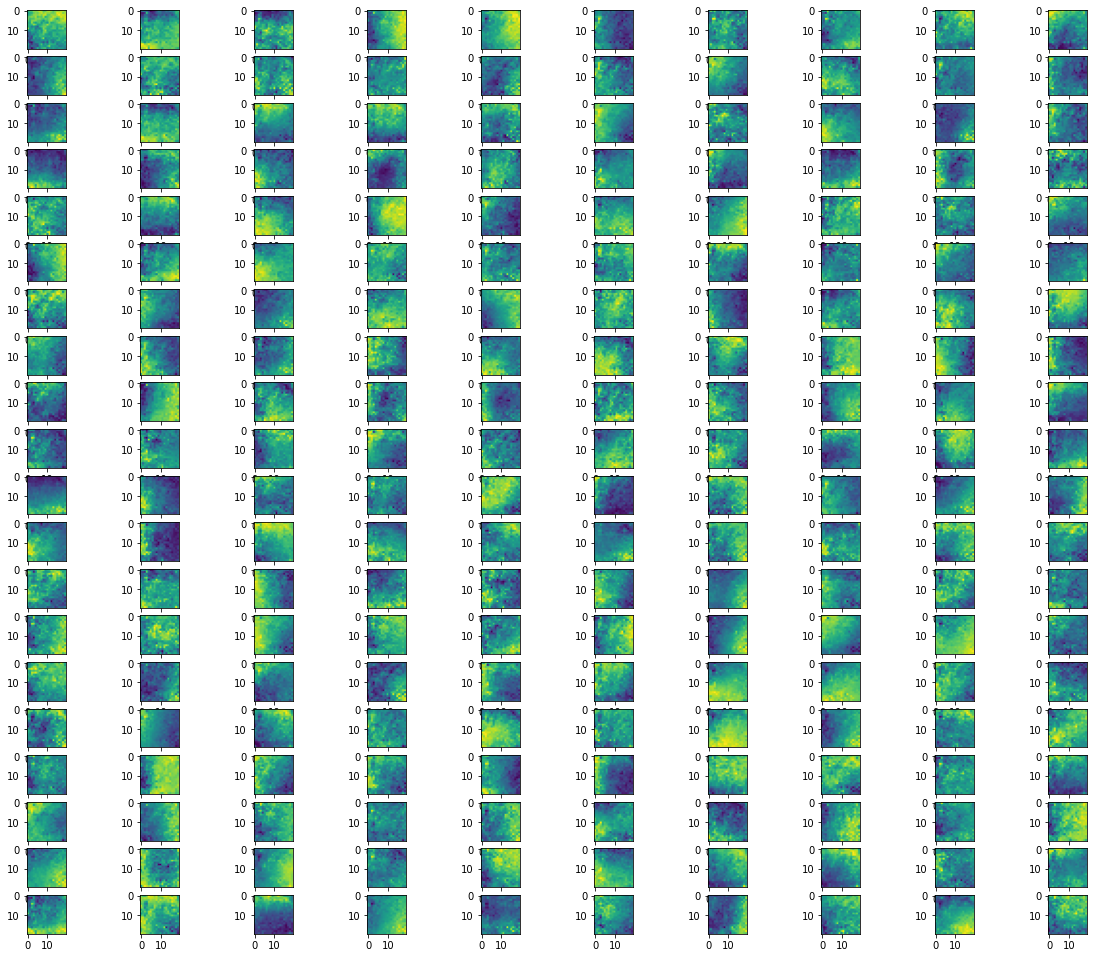

In [12]:
act_array_test_soft = np.array(all_activation_soft_test.cpu().detach().numpy())
act_array_soft1 = np.reshape(act_array_test_soft, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array_soft1[n,:]
    counter[xbin-1,ybin-1] += 1

final_array_soft3 = final_array_soft / counter   
    
import matplotlib.pyplot as plt

N_softmax_neurons = 200
plt.figure(figsize=(20, 17))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_soft3[:,:,n])
print('Softmax layer')
plt.savefig('softmax_neurons.png')



0.00036706164
var
0.0701647


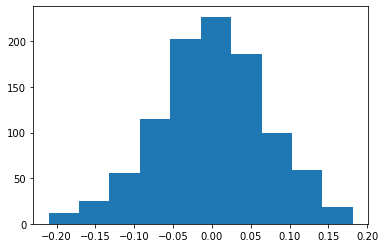

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
r = 0.4
noise_linear2  = torch.empty(1000, device='cuda:0').normal_(mean=0,std=0.7)/10
plt.hist(noise_linear2.cpu().detach().numpy())
print(np.mean(noise_linear2.cpu().detach().numpy()))
print('var')
print(np.std(noise_linear2.cpu().detach().numpy()))

(array([3.59223e+05, 8.03510e+04, 4.44320e+04, 1.91760e+04, 6.57000e+03,
        1.61000e+03, 4.67000e+02, 1.30000e+02, 3.70000e+01, 4.00000e+00]),
 array([0.        , 0.00290156, 0.00580311, 0.00870467, 0.01160622,
        0.01450778, 0.01740933, 0.02031089, 0.02321244, 0.026114  ,
        0.02901555], dtype=float32),
 <BarContainer object of 10 artists>)

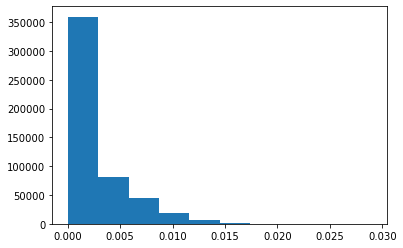

In [14]:
plt.hist(act_array1.flatten())

In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

from train import Training

mini_batch_size = 128 #intentar 32,64 
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

import time
start_time = time.time()
t_traject = train_traject
## disable cudnn fixed the mem leak problem
torch.backends.cudnn.enabled = False
        
train = Training()
all_losses, all_activation, all_activation_soft, batch_y1, y2, my_network  = train.train_model()
#all_losses1, all_activation_soft
# fig, ax = plt.subplots (2, 2)
# ax[0, 0].plot (all_losses[1:], c='b', label='total')
# ax[0, 0].set_title ('total loss')
# ax[0, 1].plot (all_losses1[1:], c='g', label='MSEloss')
# ax[0, 1].set_title ('MSEloss')
# ax[1, 0].plot (all_losses2[1:], c='r', label='firing')
# ax[1, 0].set_title ('firing')
# plt.show ()

torch.save(my_network,'/kaggle/working/MyNetworkKaggle5.tar')

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')
print('done')
timedelta = time.time() - start_time

print(f"The program took {timedelta} seconds to run")	

train
Is cuda available in train.py?: True
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
3
2
y size:
465920
y_rot1 size:
465920
Epoch: 100 completed
6.837084382772446
added mem: 1970.33984375
Epoch: 200 completed
6.555978376418352
added mem: 0.0
Epoch: 300 completed
6.35554987564683
added mem: 0.0
Epoch: 400 completed
6.157652147114277
added mem: 0.0
Epoch: 500 completed
6.007033873349428
added mem: 0.0
Epoch: 600 completed
5.716488193720579
added mem: 0.0
Epoch: 700 completed
5.6235631220042706
added mem: 0.0
Epoch: 800 completed
5.41953794285655
added mem: 0.0
Epoch: 900 completed
5.215060390532017
added mem: 0.0
done
The program took 1829.6503353118896 seconds to run


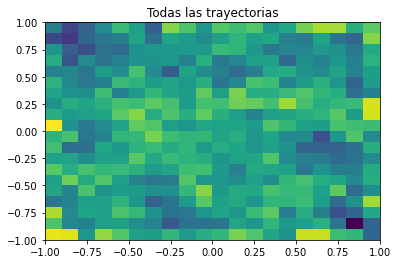

In [16]:
linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

fig, ax = plt.subplots(1,1)
ax.hist2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
plt.title('Todas las trayectorias')
plt.savefig('all_trajects.png')
plt.show()

In [17]:
hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

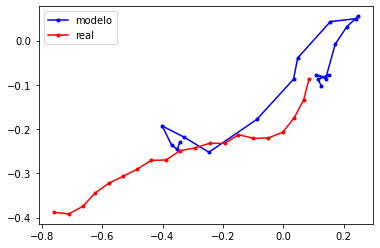

In [18]:
axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

fig, ax = plt.subplots(1,1)
ax.plot(y2[-1,:,0].cpu().detach().numpy(), y2[-1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[-1,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_example.png')
plt.show()

In [19]:
last_loss = all_losses[-1]
print(last_loss)

tensor(5.6140, device='cuda:0')


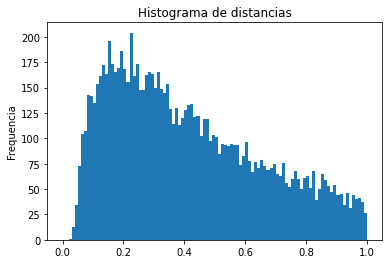

In [20]:
diferencia_array = np.zeros((2, y2[:,0,0].cpu().detach().numpy().size))

for i in range(y2[:,0,0].cpu().detach().numpy().size):
    x_dis, y_dis = distancia_modelo_real(y2[i, :, :].cpu().detach().numpy(), batch_y1[i, :, :].cpu().detach().numpy())
    diferencia_array[:,i] = [x_dis, y_dis]

plt.hist(diferencia_array[0,:], bins=100, range=[0, 1])
plt.gca().set(title='Histograma de distancias', ylabel='Frequencia')
plt.savefig('distance.png')
plt.show()

In [21]:
 N_hidden_neurons = 100


(array([1.0000e+02, 1.3500e+02, 1.6400e+02, 1.7400e+02, 2.2200e+02,
        3.1800e+02, 3.7600e+02, 5.2400e+02, 5.9500e+02, 7.7300e+02,
        9.9600e+02, 1.3210e+03, 1.6100e+03, 1.9470e+03, 2.5070e+03,
        3.0310e+03, 4.0440e+03, 4.9990e+03, 6.0800e+03, 7.6390e+03,
        9.5750e+03, 1.1986e+04, 1.4750e+04, 1.7976e+04, 2.1355e+04,
        2.5250e+04, 2.8311e+04, 2.8711e+04, 2.5182e+04, 1.9604e+04,
        1.1643e+04, 4.3410e+03, 1.0290e+03, 1.9800e+02, 1.5000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

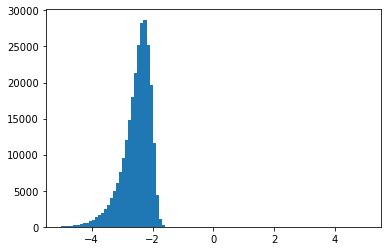

In [22]:
plt.hist(np.log10(act_array1.flatten() + 0.00000001), bins=100, range=[-5,5])

In [23]:
np.max(act_array1.flatten())

0.029015552

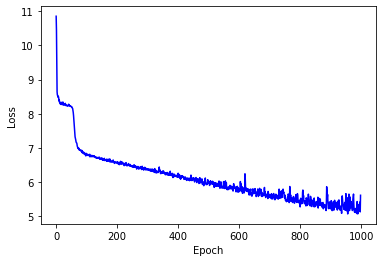

In [24]:
act_array = np.array(all_activation.cpu().detach().numpy())
act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

final_array = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1

plt.plot(all_losses[1:].cpu().detach().numpy(), c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss1.png')
plt.show()

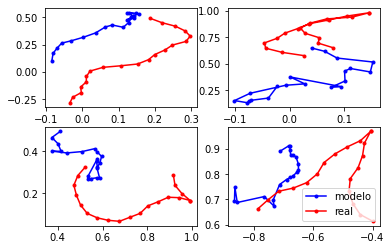

In [25]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[1,:,0].cpu().detach().numpy(), y2[1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[1,:,0].cpu().detach().numpy(), batch_y1[1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[2,:,0].cpu().detach().numpy(), y2[2,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[2,:,0].cpu().detach().numpy(), batch_y1[2,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[3,:,0].cpu().detach().numpy(), y2[3,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_examples.png')

In [26]:
batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1]

(array([-0.7864298 , -0.75175905, -0.7152316 , -0.6667503 , -0.62152547,
        -0.5856221 , -0.5629154 , -0.52625054, -0.48464027, -0.44086304,
        -0.40653455, -0.40653455, -0.42704535, -0.43365803, -0.44868958,
        -0.47480315, -0.47916538, -0.46629116, -0.44131997, -0.39902374],
       dtype=float32),
 tensor([0.6622, 0.6982, 0.7323, 0.7446, 0.7659, 0.8007, 0.8452, 0.8792, 0.9070,
         0.9311, 0.9675, 0.9675, 0.9219, 0.8723, 0.8246, 0.7820, 0.7322, 0.6839,
         0.6405, 0.6139], device='cuda:0'))

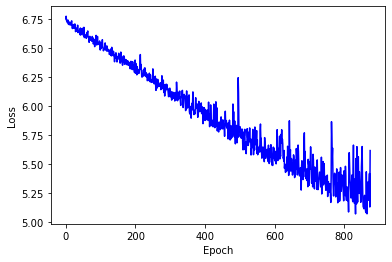

In [27]:
plt.plot(all_losses[125:].cpu().detach().numpy(), c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png')
plt.show()

In [28]:
N_softmax_neurons = 200
act_array_soft = np.array(all_activation_soft.cpu().detach().numpy())
act_array2 = np.reshape(act_array_soft, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
    counter_soft[xbin-1,ybin-1] += 1
print('done')

done


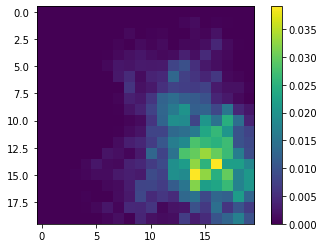

In [29]:
final_array5 = final_array / counter
final_array6 = final_array5[:,:,2]
plt.imshow(final_array6)
plt.colorbar()

In [30]:
final_array6

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.20399323e-04, 1.26428296e-03, 0.00000000e+00,
        4.36845814e-04, 1.60152346e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.29355912e-04,
        9.81332996e-04, 0.00000000e+00, 4.44959835e-04, 5.16604191e-04,
        0.00000000e+00, 1.20489821e-04, 1.06827707e-03, 5.0864

(array([[20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [17.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [14.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 8.,  7.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 8.,  4.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 7.,  1.,  2.,  4.,  3.,  3.,  0.,  0.,  0.,  0.],
        [ 6.,  2.,  2.,  2.,  4.,  3.,  0.,  1.,  0.,  0.],
        [ 6.,  4.,  2.,  3.,  0.,  0.,  0.,  2.,  2.,  1.],
        [ 5.,  5.,  2.,  1.,  1.,  2.,  2.,  0.,  2.,  0.],
        [ 8.,  1.,  2.,  3.,  0.,  1.,  

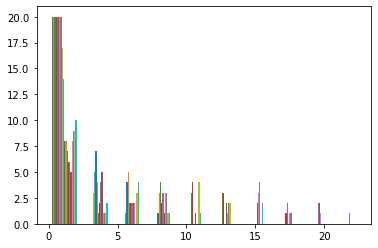

In [31]:
plt.hist(final_array[:,:,2])

Hidden layer


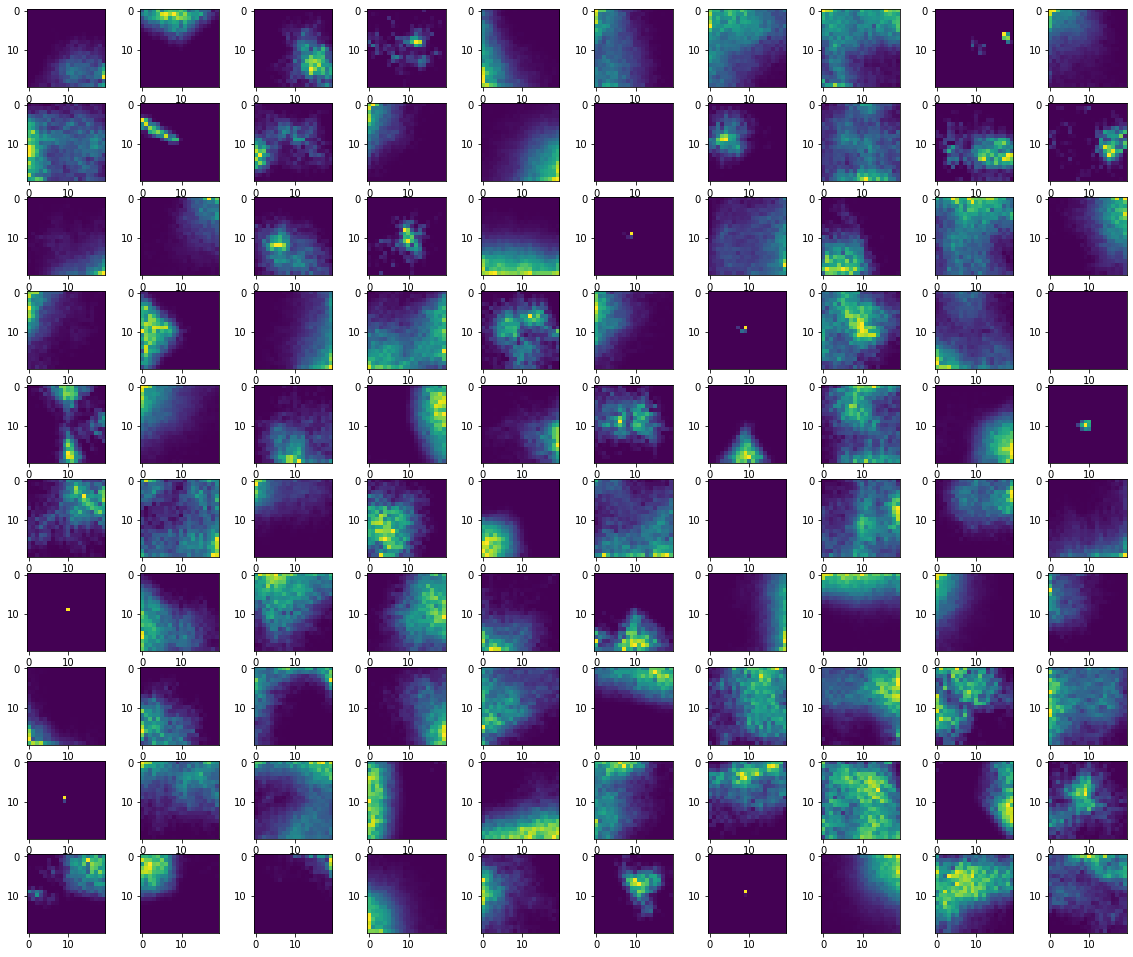

In [32]:
N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons.png')

#Var(Time, batch)   activaciones recurrente
#Ruido

#Mayor beta, ruido en la softmax también, =/= n° neuronas

Hidden layer


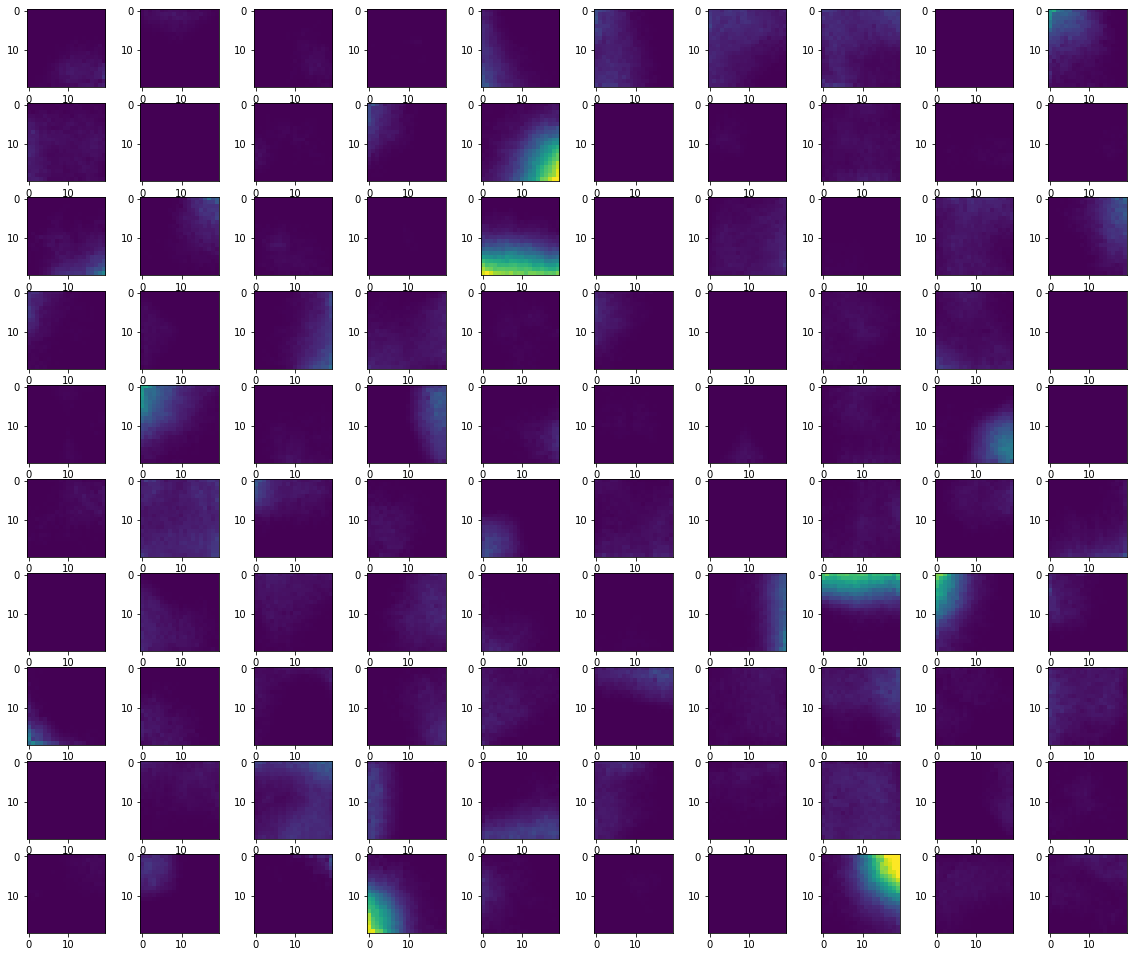

In [33]:
final_arrayplot = final_array / counter
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_arrayplot[:,:,n], vmin=0, vmax=1)
print('Hidden layer')
plt.savefig('hidden_neurons1.png')


(array([1.10000e+01, 1.40000e+01, 2.10000e+01, 2.20000e+01, 1.90000e+01,
        2.60000e+01, 3.60000e+01, 5.20000e+01, 4.90000e+01, 7.90000e+01,
        9.70000e+01, 1.39000e+02, 1.61000e+02, 1.91000e+02, 2.68000e+02,
        3.46000e+02, 4.35000e+02, 5.49000e+02, 6.71000e+02, 8.49000e+02,
        1.04900e+03, 1.27300e+03, 1.68600e+03, 2.06200e+03, 2.59600e+03,
        3.30500e+03, 4.18700e+03, 5.12200e+03, 6.44600e+03, 8.36100e+03,
        1.02820e+04, 1.28820e+04, 1.64090e+04, 2.03570e+04, 2.58720e+04,
        3.25020e+04, 4.08800e+04, 5.13970e+04, 6.37830e+04, 8.04330e+04,
        1.00929e+05, 1.25828e+05, 1.53593e+05, 1.81224e+05, 2.04998e+05,
        2.15698e+05, 2.12892e+05, 1.89090e+05, 1.48039e+05, 1.04925e+05,
        5.66860e+04, 2.01290e+04, 5.13400e+03, 1.33700e+03, 4.52000e+02,
        7.70000e+01, 5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

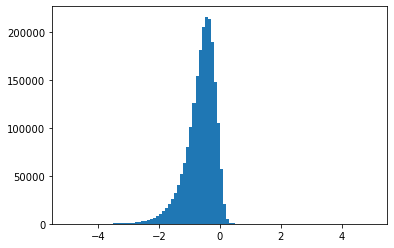

In [34]:
plt.hist(np.log10(act_array1.flatten() + 0.00000001), bins=100, range=[-5,5])

In [35]:
np.max(act_array1.flatten())

4.605735

Softmax layer


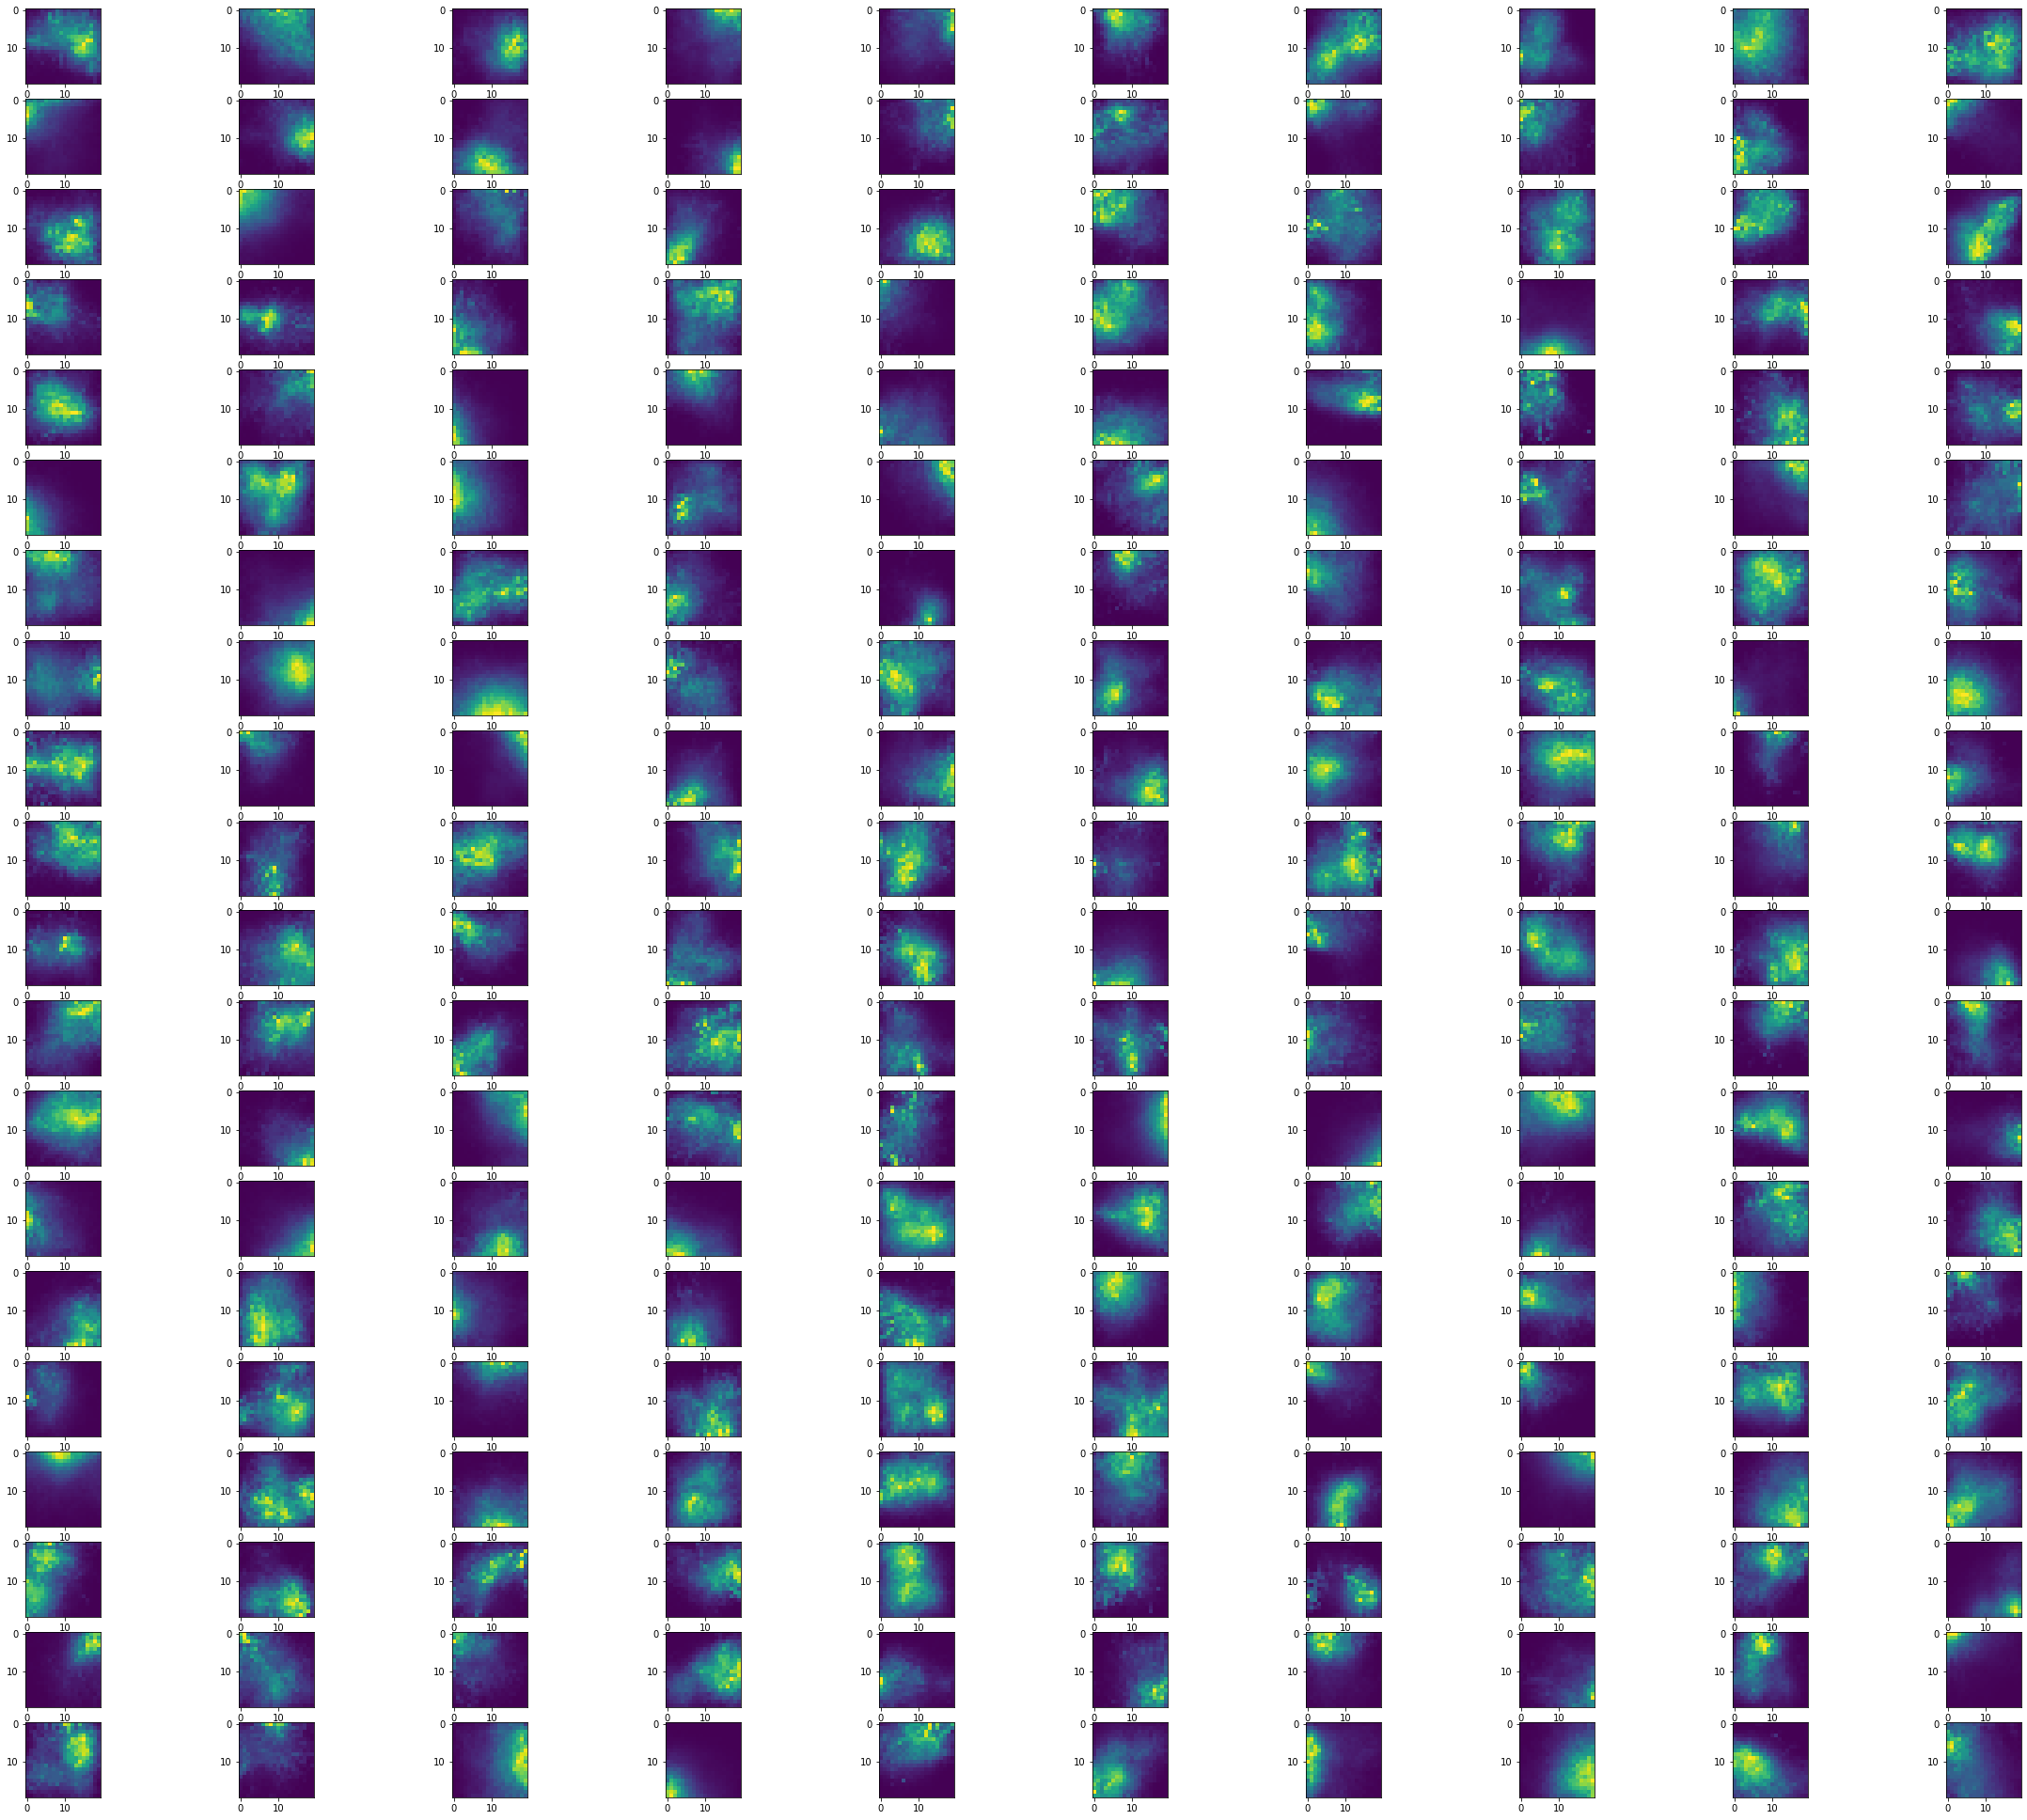

In [36]:
N_softmax_neurons = 200
final_array_soft = final_array_soft / counter_soft
final_array2 = final_array_soft[:,:,0]
plt.figure(figsize=(40, 35))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_soft[:,:,n])
print('Softmax layer')
plt.savefig('softmax_neurons.png')

In [37]:
sum(final_array_soft[0,0,:])

1.0000000020334732

In [38]:
all_activation_soft.sum(2)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0')

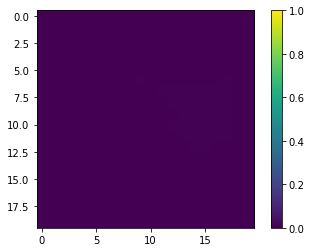

In [39]:
plt.imshow(final_array_soft[:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [40]:
sum(final_array_soft[0,0,:])

1.0000000020334732

In [41]:
sum(counter_soft[0,0,:])

706.0

In [42]:
final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
    counter_soft[xbin-1,ybin-1] += 1
print('done')

done


Softmax layer


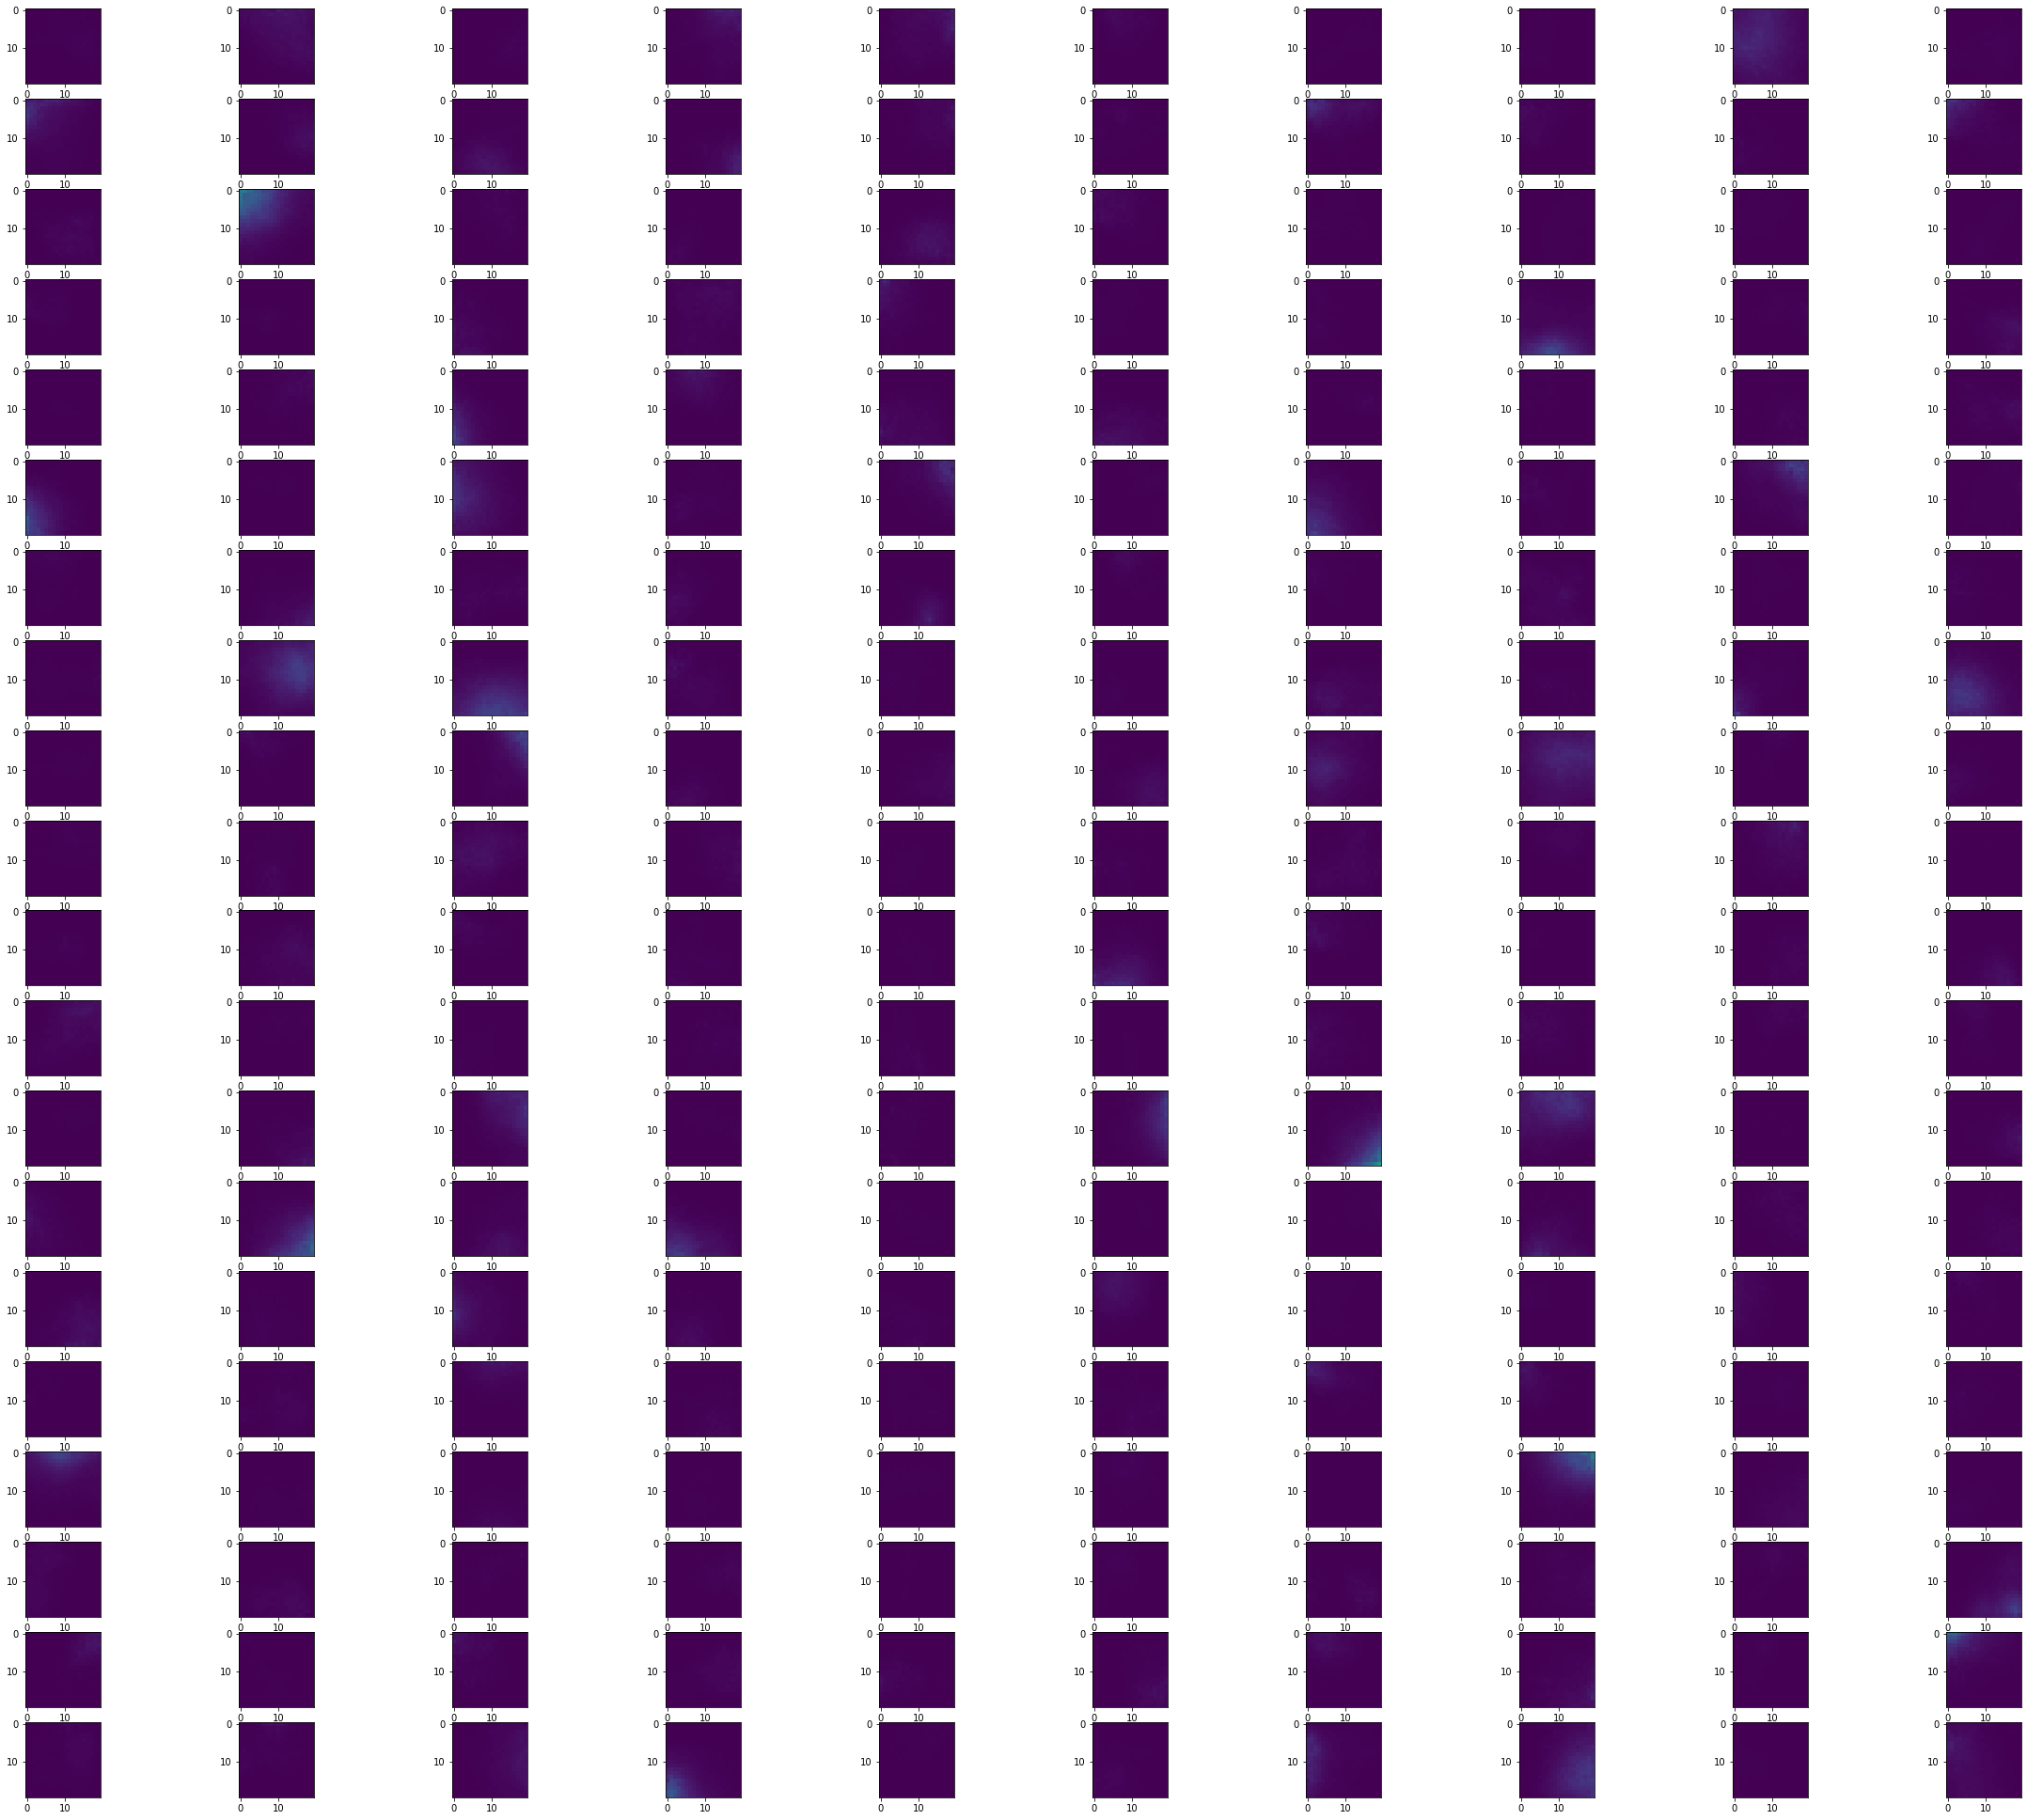

In [43]:
final_array_softmax = final_array_soft / counter_soft
plt.figure(figsize=(40, 35))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_softmax[:,:,n], vmin=0, vmax=0.5)
print('Softmax layer')
plt.savefig('softmax_neurons1.png')


In [44]:
# f = final_array_soft.flatten()
# plt.hist(np.log10(f), bins=30)

In [45]:
# plt.figure()
# final_array2 = np.log10(final_array_soft[:,:,0])
# plt.imshow(final_array2)
# plt.colorbar()

# plt.figure()
# final_array3 = np.log10(final_array_soft[:,:,1])
# plt.imshow(final_array3)
# plt.colorbar()
# print(np.max(np.abs(final_array_soft[:,:,0]-final_array_soft[:,:,1])))

In [46]:
# from test import Testing
# import numpy as np
# N_despl = 20
# N_coord = 2
# N_hidden_neurons = 100
# N_softmax_neurons = 200
# test_traject = 256
# limit_arena = 1
# limit_arena2 = -1

# t_traject = test_traject
        
# test = Testing()
# loss1, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network  = test.test_model()

# linear_size = t_traject * N_despl

# data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
# data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# # data[20,224] or [32,20] tiempo,N_traject


# data_x = np.reshape(data_x, -1, order='F')
# data_y = np.reshape(data_y, -1, order='F')

# hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
# inx = np.digitize(data_x, edges[0], right=True)
# iny = np.digitize(data_y, edges[1], right=True)

# axisbins = list(zip(inx, iny))
# axisbins = np.array(axisbins)


# act_array_test = np.array(all_activation_test.cpu().detach().numpy())
# act_array1 = np.reshape(act_array_test, [linear_size, N_hidden_neurons], order = 'C')

# final_array = np.zeros([20,20,N_hidden_neurons])
# counter = np.zeros([20,20])
# counter = np.expand_dims(counter, 2)

# for n in range(linear_size):
#     xbin = axisbins[n,0]
#     ybin = axisbins[n,1]
#     final_array[xbin-1,ybin-1,:] += act_array1[n,:]
#     counter[xbin-1,ybin-1] += 1
    
# print(f'loss = {loss1}')
# print('done')

# final_array3 = final_array / counter

# import matplotlib.pyplot as plt

# N_hidden_neurons = 100
# plt.figure(figsize=(20, 17))
# for n in range(N_hidden_neurons):
#     ax = plt.subplot(10, 10, n + 1)
#     ax.imshow(final_array3[:,:,n])
# print('Hidden layer')
# plt.savefig('hidden_neurons_rot.png')

In [47]:
# import matplotlib.pyplot as plt

# N_hidden_neurons = 100
# plt.figure(figsize=(20, 17))
# for n in range(N_hidden_neurons):
#     ax = plt.subplot(10, 10, n + 1)
#     ax.imshow(final_array3[:,:,n], vmin=0, vmax=1)
# print('Hidden layer')
# plt.savefig('hidden_neurons_rot2.png')

In [48]:
# act_array_test_soft = np.array(all_activation_soft_test.cpu().detach().numpy())
# act_array_soft1 = np.reshape(act_array_test_soft, [linear_size, N_softmax_neurons], order = 'C')

# final_array_soft = np.zeros([20,20,N_softmax_neurons])
# counter = np.zeros([20,20])
# counter = np.expand_dims(counter, 2)

# for n in range(linear_size):
#     xbin = axisbins[n,0]
#     ybin = axisbins[n,1]
#     final_array_soft[xbin-1,ybin-1,:] += act_array_soft1[n,:]
#     counter[xbin-1,ybin-1] += 1

# final_array_soft3 = final_array_soft / counter   
    
# import matplotlib.pyplot as plt

# N_softmax_neurons = 200
# plt.figure(figsize=(20, 17))
# for n in range(N_softmax_neurons):
#     ax = plt.subplot(20, 10, n + 1)
#     ax.imshow(final_array_soft3[:,:,n])
# print('Softmax layer')
# plt.savefig('softmax_neurons_rot.png')

In [49]:
# peso = my_network.linear3.weight
# peso1 = peso.cpu().detach().numpy()
# plt.plot(peso1.T[:,0], peso1.T[:,10], ".")

(array([  3.,   6.,  17., 124., 109., 114.,  18.,   6.,   2.,   1.]),
 array([-4.6155987 , -3.5930026 , -2.5704064 , -1.5478103 , -0.5252142 ,
         0.49738193,  1.519978  ,  2.5425742 ,  3.5651703 ,  4.5877666 ,
         5.6103625 ], dtype=float32),
 <BarContainer object of 10 artists>)

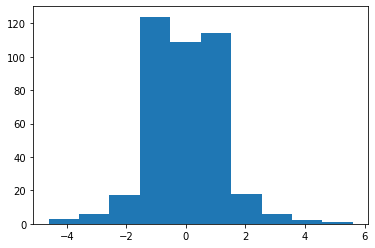

In [50]:
peso = my_network.linear3.weight
peso2 = peso.cpu().detach().numpy().flatten()
plt.hist(peso2)

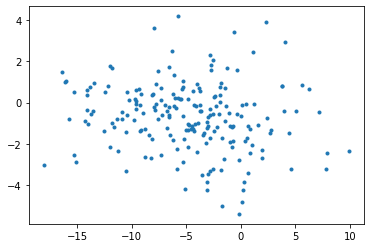

In [51]:
peso = my_network.linear5.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

(array([6.0000e+00, 3.1000e+01, 9.9000e+01, 3.1800e+02, 9.5700e+02,
        3.7430e+03, 1.0426e+04, 4.0760e+03, 3.3000e+02, 1.4000e+01]),
 array([-21.487528 , -18.273037 , -15.058545 , -11.844053 ,  -8.629561 ,
         -5.41507  ,  -2.2005785,   1.013913 ,   4.2284045,   7.4428964,
         10.657388 ], dtype=float32),
 <BarContainer object of 10 artists>)

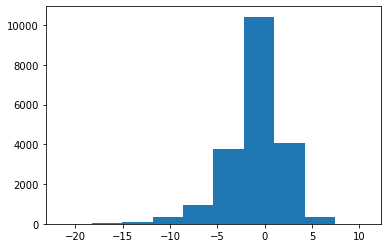

In [52]:
peso = my_network.linear5.weight
peso1 = peso.cpu().detach().numpy().flatten()
plt.hist(peso1)

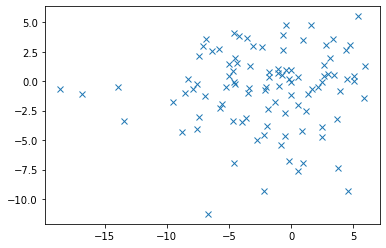

In [53]:
peso = my_network.linear4.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], "x")

In [54]:
np.min(peso1)

-33.654423

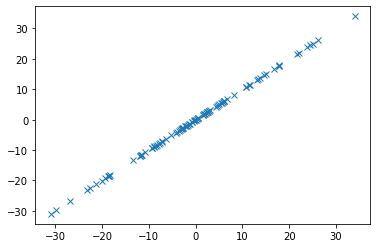

In [55]:
peso = my_network.linear.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[0,:], peso1.T[0,:], "x")

In [56]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[1,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[2,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[3,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

In [57]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# fig, ax = plt.subplots(1,1)
# ax.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.show()

In [58]:
# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[0,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[1,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[2,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[3,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

In [59]:

# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

# ax1.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax1.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax2.plot(y2[1,:,0].cpu().detach().numpy(), y2[1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax2.plot(batch_y1[1,:,0].cpu().detach().numpy(), batch_y1[1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax3.plot(y2[2,:,0].cpu().detach().numpy(), y2[2,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax3.plot(batch_y1[2,:,0].cpu().detach().numpy(), batch_y1[2,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax4.plot(y2[3,:,0].cpu().detach().numpy(), y2[3,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax4.plot(batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.savefig('traject_examples.png')

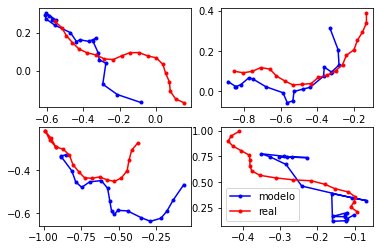

In [60]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[50,:,0].cpu().detach().numpy(), y2[50,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[50,:,0].cpu().detach().numpy(), batch_y1[50,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[51,:,0].cpu().detach().numpy(), y2[51,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[51,:,0].cpu().detach().numpy(), batch_y1[51,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[52,:,0].cpu().detach().numpy(), y2[52,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[52,:,0].cpu().detach().numpy(), batch_y1[52,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[53,:,0].cpu().detach().numpy(), y2[53,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[53,:,0].cpu().detach().numpy(), batch_y1[53,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

In [61]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[1,:,:].cpu().detach().numpy())

In [62]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[5,:,:].cpu().detach().numpy())

In [63]:
# all_activation_soft[5,:,69].cpu().detach().numpy()

In [64]:
# fig, ax = plt.subplots(1,1)
# ax.plot(y2[5,:,0].cpu().detach().numpy(), y2[5,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax.plot(batch_y1[5,:,0].cpu().detach().numpy(), batch_y1[5,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.show()

In [65]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[10,:,:].cpu().detach().numpy())

In [66]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())

In [67]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[15,:,:].cpu().detach().numpy())

In [68]:
all_activation_soft

tensor([[[5.8482e-03, 1.0595e-04, 1.0268e-02,  ..., 2.3169e-03,
          3.0452e-05, 6.2945e-05],
         [1.7225e-02, 3.2760e-04, 1.5810e-02,  ..., 5.0463e-03,
          1.0865e-04, 1.9022e-03],
         [3.4298e-02, 7.1222e-04, 1.1411e-02,  ..., 8.2934e-03,
          2.9289e-05, 2.2029e-03],
         ...,
         [5.4340e-05, 1.3039e-02, 4.6940e-04,  ..., 4.8500e-02,
          1.0394e-03, 1.3469e-02],
         [3.2318e-05, 1.6295e-02, 6.6529e-04,  ..., 5.1885e-02,
          9.1300e-04, 1.7074e-02],
         [1.5420e-05, 1.7226e-02, 5.1699e-04,  ..., 4.5525e-02,
          7.2105e-04, 1.8525e-02]],

        [[3.1025e-03, 7.0872e-05, 1.9748e-02,  ..., 1.4254e-03,
          1.3753e-05, 1.7054e-06],
         [1.4959e-02, 1.4651e-04, 7.0876e-02,  ..., 3.1605e-03,
          4.6701e-05, 3.3704e-04],
         [2.9483e-02, 3.8031e-04, 2.4260e-02,  ..., 7.5822e-03,
          1.5406e-05, 4.3483e-04],
         ...,
         [9.0353e-04, 1.1034e-01, 2.8455e-05,  ..., 5.8327e-02,
          7.538

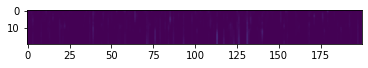

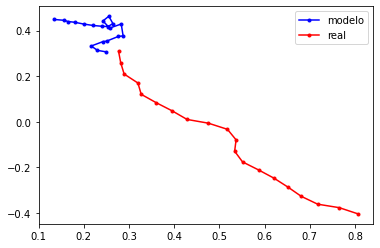

In [69]:
plt.imshow(all_activation_soft[20,:,:].cpu().detach().numpy(), vmin=0, vmax=1)
fig, ax = plt.subplots(1,1)
ax.plot(y2[20,:,0].cpu().detach().numpy(), y2[20,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[20,:,0].cpu().detach().numpy(), batch_y1[20,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.show()

In [70]:
all_activation_soft[20,:,[33,34]]

tensor([[7.4072e-04, 1.1424e-04],
        [9.4956e-04, 2.4058e-03],
        [9.4098e-04, 6.7505e-03],
        [1.2087e-03, 1.2289e-02],
        [1.2467e-03, 5.5842e-03],
        [1.9699e-03, 4.8631e-03],
        [2.5237e-03, 5.7759e-03],
        [3.0015e-03, 3.2889e-03],
        [4.6500e-03, 2.7712e-03],
        [4.8381e-03, 1.7158e-03],
        [4.0975e-03, 6.5619e-04],
        [2.2743e-03, 1.5898e-04],
        [9.6893e-04, 5.0971e-05],
        [6.1362e-04, 2.7307e-05],
        [4.2040e-04, 1.4909e-05],
        [3.2999e-04, 1.0041e-05],
        [2.9344e-04, 8.4008e-06],
        [3.1658e-04, 8.6470e-06],
        [5.2467e-04, 1.0486e-05],
        [4.2710e-04, 4.2355e-06]], device='cuda:0')

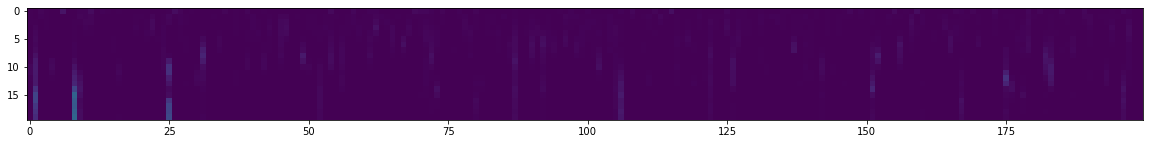

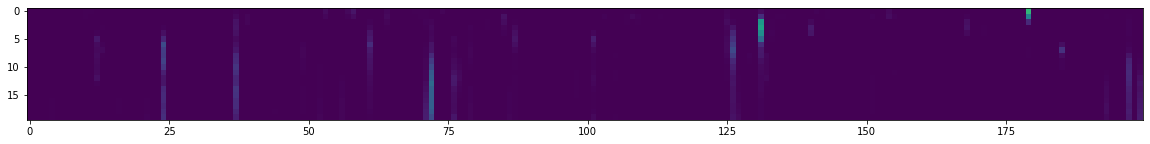

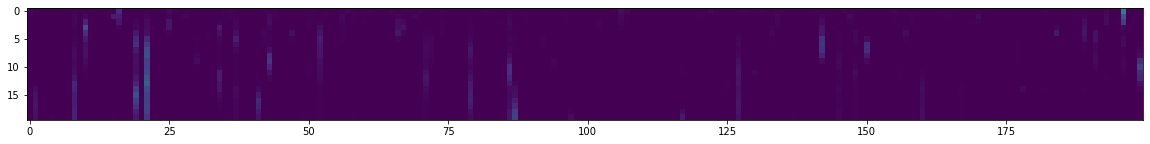

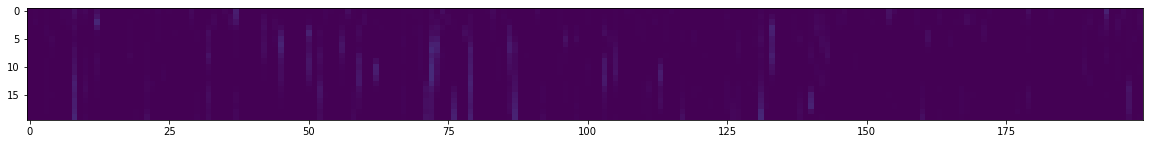

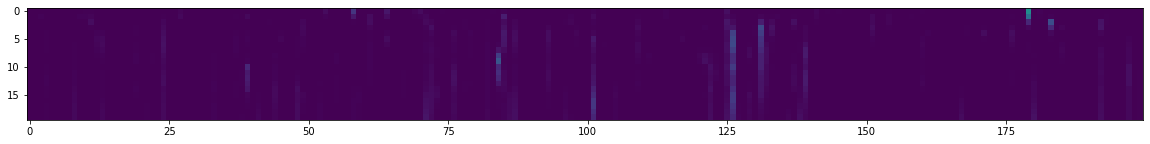

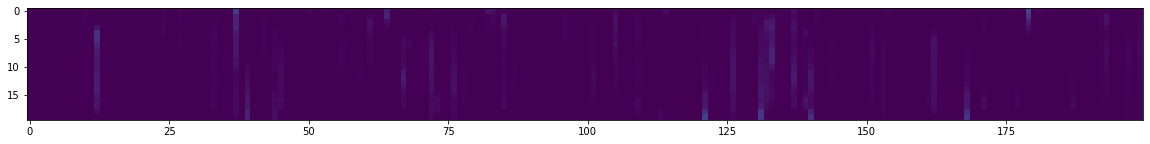

In [71]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[120,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[121,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[122,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[123,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[124,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[125,:,:].cpu().detach().numpy(), vmin=0, vmax=1)